In [1]:
%load_ext watermark
%watermark -v -m -p numpy,scipy,pandas,matplotlib,sklearn -g 

CPython 3.5.2
IPython 6.4.0

numpy 1.14.5
scipy 1.1.0
pandas 0.23.1
matplotlib 2.2.2
sklearn 0.19.1

compiler   : GCC 5.4.0 20160609
system     : Linux
release    : 4.9.89-boot2docker
machine    : x86_64
processor  : x86_64
CPU cores  : 2
interpreter: 64bit
Git hash   :


In [2]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
import glob as gl
warnings.filterwarnings('ignore')
from glob import glob
import os
import pickle
#pip install tqdm
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import json
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
%matplotlib inline
import datetime
from datetime import datetime, date, time,timedelta
# настройка внешнего вида графиков в seaborn
sns.set_context(
    "notebook", 
    font_scale = 1.5,       
    rc = { 
        "figure.figsize" : (12, 9), 
        "axes.titlesize" : 18 
    }
)

import requests
from xml.etree import ElementTree as ET
from datetime import datetime, date, time
from datetime import timedelta

import collections

import warnings
warnings.filterwarnings('ignore')
import json
import random
RANDOM_STATE = 17
random.seed(RANDOM_STATE)

import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV,Lasso,Ridge 
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV, StratifiedKFold,cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Reshape
from keras.layers.recurrent import LSTM,SimpleRNN,GRU
from keras.engine.topology import Input
from keras.models import Sequential
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVR

import matplotlib.pyplot as plt
%matplotlib inline


Using TensorFlow backend.


In [9]:
start_date = datetime.strptime("2012-50-1", "%Y-%W-%w")
end_date = datetime.strptime("2018-34-1", "%Y-%W-%w") #not less than last date of data
PATH_TO_DATA = '/notebooks/misha/data/csv/'

#parsing file with fixed structure=================================
init_columns_inp_data = ['item_id', 'trans_id', 'empty', 'doc_id', 'name_text',
                      'sell_subnum', 'date', 'sell_big', 'piece_text','house_id','house_name']
init_buffer_file_name = 'buffer.txt'
sell_roll_mean = 7
init_doc_line_len = 1000000
init_doc_line_offset = 2
house_vocab = {}
item_vocab = {}
sub_num_limit = 10000
#==================================================================
#generating master table with parameters:
sel_house_ids = [
                 #2720, 2500, 
                 #2501, 2310, 
                 #2700, 2699, 1100, 2640, 2710, 2200, 
                 #2820, 2650, 2400, 2320, 2210, 2630, 2600, 2300, 2410, 2800, 
                 #2610, 
                2100 
                #,2110, 2420, 2810, 2620, 2730, 2430
                ]
sel_item_ids = [ ]

#==========================curency parameters=============================
cr_local_data = True
cr_file_name = 'filename.xml'
cr_url='http://www.cbr.ru/scripts/XML_dynamic.asp?date_req1=%s&date_req2=%s&VAL_NM_RQ=R01235'%(start_date.strftime("%d/%m/%Y"),end_date.strftime("%d/%m/%Y"))
cr_rolling_mean = 7


In [10]:
#=========================get auxilary data===========================

def create_wrk_week_df(inp_file='./data/calendar/content.json'):
    #============================ building calendar dataframe=========================================####
    with open(inp_file, encoding="utf-8") as f:
        calendar_json = json.load(f)

    #building calendar
    cld_inp = pd.DataFrame([],columns = ['year','month','days'])
    for k in calendar_json:
        month_num = 1
        for j in ['Январь','Февраль','Март','Апрель','Май','Июнь','Июль','Август','Сентябрь','Октябрь','Ноябрь','Декабрь']:
            cld_inp.loc[len(cld_inp)]=[int(k['Год/Месяц']),month_num,list(map(int, [x for x in k[j].replace('+','').split(',') if '*' not in x]))] 
            month_num+=1  
    #calculating working day per week
    cnt_cld_out = collections.Counter() #pd.DataFrame([],columns = ['week','wd'])
    delta_days = (end_date-start_date).days
    shift_day = timedelta(1) ##shift = 1 day
    day_week = 0
    week_num = 0
    act_date = start_date
    for d in range(1,delta_days+1):
        day_week+=1
        if act_date.day not in list(cld_inp.loc[(cld_inp['year']==act_date.year)&(cld_inp['month']==act_date.month)]['days'])[0]:
            #print(act_date.day)
            cnt_cld_out[week_num] += 1      
        act_date = act_date + shift_day
        if day_week >= 7:
            week_num += 1
            day_week = 0
    return cnt_cld_out

def create_wrk_day_df(inp_file='./data/calendar/content.json'):
    #============================ building calendar dataframe=========================================####
    with open(inp_file, encoding="utf-8") as f:
        calendar_json = json.load(f)

    #building calendar
    cld_inp = pd.DataFrame([],columns = ['year','month','days'])
    for k in calendar_json:
        month_num = 1
        for j in ['Январь','Февраль','Март','Апрель','Май','Июнь','Июль','Август','Сентябрь','Октябрь','Ноябрь','Декабрь']:
            cld_inp.loc[len(cld_inp)]=[int(k['Год/Месяц']),month_num,list(map(int, [x for x in k[j].replace('+','').split(',') if '*' not in x]))] 
            month_num+=1  
    #calculating working day per week
    cnt_cld_out = collections.Counter() #pd.DataFrame([],columns = ['week','wd'])
    delta_days = (end_date-start_date).days
    shift_day = timedelta(1) ##shift = 1 day
    day_week = 0
    week_num = 0
    act_date = start_date
    for d in range(0,delta_days):
        if act_date.day not in list(cld_inp.loc[(cld_inp['year']==act_date.year)&(cld_inp['month']==act_date.month)]['days'])[0]:
            cnt_cld_out[d] = 1
        else:
            cnt_cld_out[d] = 0   
        act_date = act_date + shift_day
    return cnt_cld_out

def get_curr_df(local_data=cr_local_data,file_name=cr_file_name,url=cr_url,rolling_mean=cr_rolling_mean):
    #============================ building currency data=========================================####
    def lookup(s): #VERY FAST
        dates = {date:pd.to_datetime(date,format='%d.%m.%Y') for date in s.unique()}
        return s.map(dates)

    if local_data:
        #get data from file
        tree = ET.parse(file_name)
        root = tree.getroot()
    else:
        #from server and save to file
        response = requests.get(url)
        root = ET.fromstring(response.content)
        tree = ET.ElementTree(root)
        tree.write(file_name)

    data_out = pd.DataFrame({'date': list([x.attrib['Date'] for x in root]),'cv': list(map(lambda s: s.replace(',' , '.'), [x[1].text for x in root]))})
    data_out['date'] = lookup(data_out['date'])
    data_out['cv'] = data_out['cv'].astype(float)
    data_out = data_out.set_index('date')
    data_out = data_out.reindex(pd.date_range(start_date,end_date))
    data_out = data_out.fillna(method='ffill')
    data_out = data_out.fillna(method='bfill')
    data_out['cd'] = data_out['cv'].diff(1)
    data_out['cd'] = data_out['cd'].fillna(method='bfill')
    data_out['cv'] = data_out['cv'].rolling(rolling_mean).mean()
    data_out['cv'] = data_out['cv'].fillna(method='bfill')
    data_out['cd'] = data_out['cd'].rolling(rolling_mean).mean()
    data_out['cd'] = data_out['cd'].fillna(0)
    return data_out

wrk_cld_per_week = create_wrk_week_df(inp_file='./data/calendar/content.json')
wrk_cld_per_day = create_wrk_day_df(inp_file='./data/calendar/content.json')
curr_df = get_curr_df()


def get_work_day_per_week(x,calendar_df = wrk_cld_per_week):
    return calendar_df[x['date_week_long']]
def get_work_day_per_day(x,calendar_df = wrk_cld_per_day):
    return calendar_df[x['date_day_long']]

In [48]:
def data_combiner_1(path_to_data):
    data_out = pd.DataFrame()
    for filename in gl.iglob(PATH_TO_DATA+'*', recursive=True):
        print('reading file ',filename)
        #print(os.path.join(PATH_TO_DATA,filename))
        #cut and convert csv file
        data_in = pd.read_csv(filename, encoding="cp1251",sep=';',names=init_columns_inp_data)
        data_out = pd.concat([data_in.iloc[init_doc_line_offset:],data_out]) 
    #remove empty rows and delete unused columns
    data_out =  data_out[(data_out['doc_id'].isna()==False)|(data_out['item_id'].isna()==False)].drop(['empty','piece_text'],axis = 1)
    #some manipulations for repairing data structure of initial data
    data_out.loc[data_out['house_name'].isna()==True,'item_id'] = np.nan
    #replace some " " and "/"
    data_out[['item_id','sell_big']] = data_out[['item_id','sell_big']].replace(regex={'/':'', ' ':''})
    #mark temporary rows
    data_out['tmp_flag'] = 0
    data_out.loc[data_out['doc_id'].isna()==True,'tmp_flag'] = 1
    #filling na
    data_out = data_out.fillna(method='ffill')
    #clear marked temporary rows
    data_out = data_out[data_out['tmp_flag']==0]
    #string to datetime convertion
    data_out[['item_id','trans_id','sell_subnum','doc_id','sell_big','house_id']] = data_out[['item_id','trans_id','sell_subnum','doc_id','sell_big','house_id']].apply(lambda x: pd.to_numeric(x,downcast='unsigned'))
    #filling house and items dictionary
    for k in data_out['house_id'].unique():
        if k not in house_vocab:
            house_vocab[k]=data_out[data_out['house_id']==k]['house_name'].iloc[0]
    for k in data_out['item_id'].unique():
        if k not in item_vocab:
            item_vocab[k]=data_out[data_out['item_id']==k]['name_text'].iloc[0]      
    print("===========================\nHouse dictionary\n", len(house_vocab) ,house_vocab)
    print("===========================\nItems dictionary\n",len(item_vocab),item_vocab)
    data_out =  data_out.drop(['house_name','name_text'],axis = 1)
    #Add dates
    def lookup(s): #VERY FAST
        dates = {date:pd.to_datetime(date,format='%d.%m.%Y') for date in s.unique()}
        return s.map(dates)
    data_out['date'] = lookup(data_out['date'])
    data_out = data_out[(data_out['date']>=start_date)&(data_out['date']<=end_date)]
    #sell out / sell in
    data_out['sell_out'],data_out['sell_in'] = 0,0
    data_out.loc[data_out['sell_big']>0,'sell_in']=data_out.loc[data_out['sell_big']>0,'sell_big']
    data_out.loc[data_out['sell_big']<0,'sell_out']=data_out.loc[data_out['sell_big']<0,'sell_big']*-1
    data_out['doc_id_uniq'] = data_out['doc_id']*sub_num_limit + data_out['sell_subnum']
    if data_out['sell_subnum'].max() > sub_num_limit:
        raise "increase limit for sell_subnum"
    #filter uniques
    tmp_uniq_count1 = len(data_out)
    data_out = data_out.groupby(['doc_id_uniq'],as_index = False).max()
    tmp_uniq_count2 = len(data_out)
    if tmp_uniq_count2!=tmp_uniq_count1:
        print("!!!!!!!!!!!!!!!Found %s not unique IDs !!!!!!!!!!!"%(tmp_uniq_count1-tmp_uniq_count2))  
    #===================================calculate rest===================================
    #data_out['rest'] = 0
    #data_out_help = data_out.iloc[:0]
    #for n in house_vocab:
    #    for k in item_vocab:
    #        tmp_arr = data_out[(data_out['item_id']==k)&(data_out['house_id']==n)].sort_values(by=['date','doc_id_uniq'])
    #        tmp_arr['rest'] = tmp_arr['sell_big'].iloc[:].cumsum()
    #        data_out_help = pd.concat([data_out_help,tmp_arr])
    #data_out = data_out_help
    #===================================calculate rest===================================
    tmp_columns = list(data_out.columns)
    [tmp_columns.remove(x) for x in ['house_id','item_id','date']]
    [tmp_columns.insert(0,x) for x in ['date','item_id','house_id']]
    data_out = data_out[tmp_columns]
    data_out = data_out.sort_values(by=['house_id','item_id','date','doc_id_uniq']) 
    ##Remove unused data
    data_out =  data_out.drop(['doc_id','sell_subnum','sell_big','tmp_flag'],axis = 1)
    #================================EXTERNAL DATA===============================
    #================================EXTERNAL DATA===============================
    #============================ adding working days=========================================####
    #data_out['wdperw'] = 0
    #data_out['wdperw'] = data_out.apply(get_work_day_per_week,calendar_df=wrk_cld_per_week,axis = 1)
    #============================ adding working days=========================================####
    return data_out

def data_combiner_2(data_inp,sel_house_ids = sel_house_ids,sel_item_ids = sel_item_ids):
    data_out = pd.DataFrame(data_inp['date'])
    min_date = data_out['date'].min()
    max_date = data_out['date'].max()
    data_out = data_out.reindex(pd.date_range(min_date,max_date))
    data_out['date'] = data_out.index
    total_columns = []
    for i in sel_item_ids:
        h_i_columns = []
        for h in sel_house_ids:
            data_sel_grp = data_inp[(data_inp['house_id']==h)&(data_inp['item_id']==i)].groupby(['date'],as_index = True)
            #data_sel_data = data_sel_grp.min()
            data_sel_data = pd.DataFrame(data_sel_grp.sum()[['sell_out']]) 
            data_sel_data.columns = ['%s_%s_sout'%(i,h)]
            h_i_columns.append('%s_%s_sout'%(i,h))
            total_columns.append('%s_%s_sout'%(i,h))
            data_out = pd.concat([data_out, data_sel_data], axis=1) #,'sell_in'
        data_out = data_out.fillna(0)
        data_out['sum_%s_sout'%i] = data_out[h_i_columns].sum(axis=1)
    data_col_int = list(data_out.columns)
    data_col_int.remove('date')
    data_out[data_col_int]=data_out[data_col_int].astype(int)
    data_out['total_sout']=data_out[total_columns].sum(axis=1)
    return data_out

def data_combiner_2_1(data_inp,curr_df):
    data_out = pd.DataFrame(data_inp)
    min_date = data_out['date'].min()
    max_date = data_out['date'].max()
    data_out = pd.concat([data_out, curr_df], axis=1)
    data_out = data_out.loc[(data_out.index>=min_date)&(data_out.index<=max_date)]
    return data_out

def data_combiner_3(data_inp):
    data_out = pd.DataFrame(data_inp)
    #data_out['date_year'] = pd.DatetimeIndex(data_out['date']).year
    data_out['date_month'] = pd.DatetimeIndex(data_out['date']).month
    data_out['date_day_long'] = (pd.DatetimeIndex(data_out['date'])-start_date).days
    data_out['date_week_long'] = data_out['date_day_long']//7
    data_out['date_daymonth'] = pd.DatetimeIndex(data_out['date']).day
    data_out['date_dayweek'] = pd.DatetimeIndex(data_out['date']).dayofweek
    data_out['date_month_long'] = (pd.DatetimeIndex(data_out['date']).year-start_date.year)*12+data_out['date_month']
    data_out['date_week_year'] = pd.DatetimeIndex(data_out['date']).week
    data_out['dayofyear'] = pd.DatetimeIndex(data_out['date']).dayofyear
    data_out['wd'] = 0
    data_out['wd'] = data_out.apply(get_work_day_per_day,calendar_df=wrk_cld_per_day,axis = 1)
    return data_out

def data_combiner_3_1(data_inp,mean_columns,mean_val):
    data_out = pd.DataFrame(data_inp)
    data_out[mean_columns] = data_out[mean_columns].rolling(mean_val).mean()
    data_out[mean_columns] = data_out[mean_columns].fillna(0)
    return data_out

def data_combiner_4(data_inp,tag_ftr_names=[],num_pred  = 3,ftr_only_one = True,ftr_sum=True):
    data_out = pd.DataFrame(data_inp)
    if num_pred>0:
        if ftr_sum:
            tag_ftr_names_sum = ['%s_ftr_sum'%(k) for k in tag_ftr_names]
        #Future data days
        data_out_future = data_out[tag_ftr_names]
        new_arr = pd.DataFrame(np.zeros((len(data_out_future.columns),0)))
        sel_dict = {a: ['%s_ftr_%s'%(a,l+1) for l in range(num_pred)] for a in tag_ftr_names}
        not_last_columns = []
        for i in range(num_pred):
            if -num_pred+i+1 == 0:
                tmp_ftr_col = data_out_future.iloc[i+1:]
            else:
                tmp_ftr_col = data_out_future.iloc[i+1:-num_pred+i+1]   
                _ = [ not_last_columns.append('%s_ftr_%s'%(item,i+1)) for item in tag_ftr_names]
            tmp_ftr_col.columns = ['%s_ftr_%s'%(item,i+1) for item in tag_ftr_names]
            new_arr = pd.concat([new_arr.reset_index(drop=True),tmp_ftr_col.reset_index(drop=True)],axis = 1)
        data_out = pd.concat([data_out.reset_index(drop=True),new_arr],axis = 1)
        data_out = data_out.iloc[:-num_pred]
        if ftr_sum:
            for item in tag_ftr_names:
                data_out['%s_ftr_sum'%(item)] = data_out[sel_dict[item]].sum(axis=1)
        if ftr_only_one:
            filter_columns = list(data_out.columns)
            data_out = data_out.drop(not_last_columns, axis=1)
    return data_out



In [73]:
###data_a2 = pd.concat([data_a2,pd.get_dummies(data_a2['date_month'],prefix = "dm")],axis = 1).drop('date_month',axis=1)
##data_out = pd.concat([data_a2,pd.get_dummies(data_a2['date_week_year'],prefix = "dw")],axis = 1).drop('date_week_year',axis=1)

#================================#Preparations========================================================================
#preparation 
data_out_1 = data_combiner_1(PATH_TO_DATA)

#preparation 
#FILTER:  trans_id = 601  - leave only output sale to customer
data_out_1 = data_out_1[(data_out_1['trans_id']==601)]

#preparation 
#pivoting main table => generating time-based full table with desired IDs 
#use sel_house_ids, sel_item_ids
sel_item_ids = item_vocab.keys()
data_out_2 = data_combiner_2(data_out_1,sel_house_ids = sel_house_ids,sel_item_ids = sel_item_ids)

#preparation
#add currency values
data_out_2_1 = data_combiner_2_1(data_out_2,curr_df)

#preparation 
#date generation
data_out_3 = data_combiner_3(data_out_2_1)

#preparation 
#averaging
#mean_columns = ['sum_9391402_sout','sum_8433996_sout','sum_9350503_sout']
mean_columns = []
for h in sel_house_ids:
    for i in item_vocab.keys():
        mean_columns.append('%s_%s_sout'%(i,h))
mean_columns.append('total_sout')
data_out_3_1 = data_combiner_3_1(data_out_3,mean_columns,sell_roll_mean)
print("averaginh columns:",mean_columns)

#make future features list
#preparation
auto_ftr_list = ['9350503_2100_sout'] 
data_out_4 = data_combiner_4(data_out_3_1,tag_ftr_names = auto_ftr_list,num_pred  = 30,ftr_only_one = True,ftr_sum=True)


#prepare features for fitting
filter_columns = list(mean_columns)
filter_columns.extend([
    'cd',
        'date_month', 
        'date_day_long',
        'date_dayweek', 'date_week_year',
        'wd',      
        '9350503_2100_sout_ftr_sum'
                 ])
target_name = '9350503_2100_sout_ftr_sum'
print(filter_columns)
#filter_columns
data_out_5 = data_out_4[filter_columns]

#set dummies
data_out_6 = pd.concat([data_out_5,pd.get_dummies(data_out_5['date_month'],prefix = "dm")],axis = 1).drop('date_month',axis=1)
data_out_6 = pd.concat([data_out_6,pd.get_dummies(data_out_6['date_week_year'],prefix = "dw")],axis = 1).drop('date_week_year',axis=1)
data_out_6 = pd.concat([data_out_6,pd.get_dummies(data_out_6['date_dayweek'],prefix = "ddw")],axis = 1).drop('date_dayweek',axis=1)


reading file  /notebooks/misha/data/csv/a1.csv
reading file  /notebooks/misha/data/csv/data_n2_h_all.csv
reading file  /notebooks/misha/data/csv/data_n3.1_h_all.csv
reading file  /notebooks/misha/data/csv/data_n3_h_all.csv
House dictionary
 28 {2720: 'Самара-ФТ', 2500: 'Москва-ФТ', 2501: 'Вэйпарк-ФТ', 2310: 'Сургут-ФТ', 2700: 'Уфа-ФТ', 2699: 'Казань-РС', 1100: 'Центр.склад-Фиера', 2640: 'Пенза СТАРЫЙ-ФТ', 2710: 'Оренбург-ФТ', 2200: 'Челябинск-ФТ', 2820: 'Саратов-ФТ', 2650: 'Йошкар-Ола-ФТ', 2400: 'Пермь-ФТ', 2320: 'Курган-ФТ', 2210: 'Магнитогорск-ФТ', 2630: 'Ульяновск СТАРЫЙ-ФТ', 2600: 'Казань-ФТ', 2300: 'Тюмень-ФТ', 2410: 'Киров-ФТ', 2800: 'Ульяновск-ФТ', 2610: 'Чебоксары-ФТ', 2100: 'Екатеринбург-ФТ', 2110: 'Нижний Тагил-ФТ', 2420: 'Ижевск-ФТ', 2810: 'Пенза-ФТ', 2620: 'Набережные Челны-ФТ', 2730: 'Тольятти-ФТ', 2430: 'Сыктывкар-ФТ'}
Items dictionary
 8 {3809633: 'CLIP top, Петля п/фальшп, 95гр 79T9550', 8931762: 'AVS HF, Силовой мех-м, 20F2201.05, NEW', 9350503: 'CLIP top BM, Петля п/ф

In [51]:
data_out_4.describe()
#Строим исходные графики по отдельности
#with plt.style.context('bmh'):    
#    fig = plt.figure(figsize=(45, 25))
#    plt.title('Measuring values')
#    plt.plot(data_out_4.index,data_out_4['9391402_2100_sout'],label='norm')
#    plt.plot(data_out_4.index,data_out_4['sum_9391402_sout'],label='avg')
#    plt.legend(loc="best")
#fig.savefig('date_week_long.house_id.png', bbox_inches='tight')

,3809633_2100_sout,sum_3809633_sout,8931762_2100_sout,sum_8931762_sout,9350503_2100_sout,sum_9350503_sout,8931832_2100_sout,sum_8931832_sout,9391402_2100_sout,sum_9391402_sout,...,date_day_long,date_week_long,date_daymonth,date_dayweek,date_month_long,date_week_year,dayofyear,wd,9350503_2100_sout_ftr_30,9350503_2100_sout_ftr_sum
count,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,...,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000
mean,2.809119,2.815408,37.167084,37.236618,35.840635,35.962981,43.968842,44.058529,1.482384,1.485243,...,1029.000000,146.571286,15.761381,3.001001,45.634317,25.523262,175.475738,0.676338,35.819553,1077.780819
std,7.321105,18.497611,17.449156,53.420251,22.311616,60.161283,21.253753,64.457527,1.265905,3.269457,...,577.205914,82.458482,8.783492,1.999249,18.963239,14.977572,104.820359,0.467990,21.648401,307.621866
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,30.000000,4.000000,1.000000,0.000000,13.000000,1.000000,1.000000,0.000000,0.000000,432.714286
25%,0.000000,0.000000,25.428571,0.000000,22.000000,0.000000,31.857143,0.000000,0.571429,0.000000,...,529.500000,75.000000,8.000000,1.000000,29.000000,13.000000,85.000000,0.000000,22.142857,862.142857
50%,0.714286,0.000000,34.571429,19.000000,30.142857,21.000000,41.000000,24.000000,1.142857,0.000000,...,1029.000000,147.000000,16.000000,3.000000,46.000000,25.000000,168.000000,1.000000,30.285714,1029.857143
75%,2.428571,0.000000,45.571429,50.000000,43.857143,44.000000,53.285714,54.000000,2.285714,2.000000,...,1528.500000,218.000000,23.000000,5.000000,62.000000,38.000000,266.000000,1.000000,43.928571,1279.857143
max,71.857143,502.000000,146.285714,502.000000,148.857143,764.000000,230.285714,689.000000,7.428571,32.000000,...,2028.000000,289.000000,31.000000,6.000000,78.000000,53.000000,366.000000,1.000000,148.857143,2108.000000


In [74]:
#Глобальные настройки для модели

n_mean_rolling = 1 #усреднения нет
n_prev = 30 #берем последние 50 дней 
pca_en = True
plnm = False
pca = PCA(0.95, random_state = RANDOM_STATE)
scaler = StandardScaler() #MinMaxScaler(feature_range=(-1, 1))
#scaler = MinMaxScaler(feature_range=(0, 1)) 
polynom = PolynomialFeatures(degree=2)
target_name = target_name

In [75]:
#Глобальные функции
from sklearn.preprocessing import OneHotEncoder
#Готовим мини батчи
def _load_data(data_X,data_y, n_prev):  
    """
    data should be pd.DataFrame()
    """
    docX, docY = [], []
    #if len(data_y) == 599:
    #    print(data_y[0])
    for i in range(len(data_X)-n_prev):
        docX.append(data_X[i:i+n_prev])
        docY.append(np.array(data_y)[i+n_prev]) #.as_matrix()
    alsX = np.array(docX)
    alsY = np.array(docY)
    #alsX = alsX.reshape((-1,n_prev,1))
    return alsX, alsY 

def _pca_scaler_data(data_X,fit_en,pca_en,plnm):  
    if len(data_X) !=0:
        if fit_en:
            
            X_tr_sc  = scaler.fit_transform(data_X)
            if plnm:
                X_tr_sc = polynom.fit_transform(X_tr_sc)
            if pca_en:
                X_tr_sc = pca.fit_transform(X_tr_sc)
        else:
            X_tr_sc  = scaler.transform(data_X)
            if plnm:
                X_tr_sc  = polynom.transform(X_tr_sc)
            if pca_en:
                X_tr_sc = pca.transform(X_tr_sc)   
    else:
        X_tr_sc = np.array(data_X)
        
    if len(data_X) !=0:
        X_tst_sc = scaler.transform(data_X)
        if plnm:
            X_tst_sc = polynom.transform(X_tst_sc)
        if pca_en:
            X_tst_sc = pca.transform(X_tst_sc)
    else:
        X_tst_sc = np.array(data_X)
    return X_tst_sc 

def train_test_split(X_inp,y_inp,test_size=0.2):  
    """
    This just splits data to training and testing parts
    """
    ntrn = round(len(X_inp) * (1 - test_size)) 
    X_train, y_train = X_inp[0:ntrn,:] ,y_inp[0:ntrn]
    X_test, y_test   = X_inp[ntrn:,:] ,y_inp[ntrn:]
    return (X_train, y_train), (X_test, y_test)
def X_train_test_split_df(X_inp,test_size):  
    """
    This just splits data to training and testing parts
    """
    ntrn = round(len(X_inp) * (1 - test_size)) 
    X_train = X_inp.iloc[0:ntrn] 
    X_test  = X_inp.iloc[ntrn:] 
    return (X_train, X_test)

def plot_predicted(X_inp,y_inp,model,range_low = 0,range_high=1,range_up=None,range_down=None):  
    #predicted = model.predict(X_inp.reshape(-1, X_inp.shape[1]*X_inp.shape[2]))  #for linear model 
    predicted = model.predict(X_inp)   ##For NN model 
    n_hi = round((len(X_inp)+X_inp.shape[1]) * range_high)
    n_low = round((len(X_inp)+X_inp.shape[1]) * range_low)
    with plt.style.context('bmh'):    
        plt.figure(figsize=(15, 8))
        plt.title('Measuring values') 
        df_pred = pd.DataFrame(np.insert(predicted,0,[0 for i in range(X_inp.shape[1])]),columns=['%s predicted'%target_name])
        df_real = pd.DataFrame(np.insert(y_inp,0,[0 for i in range(X_inp.shape[1])]),columns=['%s real'%target_name])
        df_pred = df_pred.iloc[n_low:n_hi]
        df_real = df_real.iloc[n_low:n_hi]
        plt.plot(df_pred['%s predicted'%target_name]); #['%s_predicted'%target_name]
        plt.plot(df_real['%s real'%target_name]); #columns=['%s_real'%target_name]
        plt.ylim([range_down,range_up])
        plt.legend(loc="best")
        #for k in range(X_train.shape[0]):
        #    plt.plot(np.insert(X_train[k,:,0],0,[0 for i in range(k)]))
        
def prepare_data_set(input_df,test_size=0.2,n_prev = 60, plnm = False,fit_en=False,pca_en = True):
    frame_df = pd.DataFrame(input_df)
    print(input_df.columns)
    print("Initial lenght of data is %s"%(len(frame_df)))
    if n_mean_rolling>1:
        for k in frame_df.columns:
            frame_df[k] = frame_df[k].rolling(n_mean_rolling).mean() #Добавляем скользящие средние
        frame_df = frame_df[frame_df.index%n_mean_rolling == 0].iloc[1:] #Прореживаем
        print("Length of filtered data piece is %s"%(len(frame_df))) 
    df_ = frame_df
    columns_fit=list(frame_df.columns)   
    columns_fit.remove(target_name)
    y = df_[target_name]
    X_train_,X_test_ = X_train_test_split_df(df_[columns_fit],test_size)
    X_train_scaled = _pca_scaler_data(X_train_,fit_en,pca_en,plnm)
    X_test_scaled  = _pca_scaler_data(X_test_,False,pca_en,plnm)
    enc = OneHotEncoder()
    X_train_scaled = X_train_scaled
    if len(X_train_scaled) ==0:
        X_scaled = X_test_scaled
    elif len(X_test_scaled) ==0:
        X_scaled = X_train_scaled
    else:
        X_scaled = np.concatenate((X_train_scaled,X_test_scaled), axis=0)
    X_,y_ = _load_data(X_scaled,y,n_prev)
    (X_train_, y_train_), (X_test_, y_test_) = train_test_split(X_,y_,test_size=test_size) 
    print("Train X shape",X_train_.shape)
    print("Train y shape",y_train_.shape)
    print("Test X shape",X_test_.shape)
    print("Test y shape",y_test_.shape)
    return df_,X_train_,y_train_,X_test_,y_test_

In [55]:
#'trans_id','sell_big','house_id','item_id','date_dayweek','date_month','date_year', \
#                 'date_month_long','date_week_long','sell_out','sell_in','rest','wdperw'

#Читаем исходные данные
df,X_train,y_train,X_test,y_test = prepare_data_set(data_out_6,test_size=0.3,n_prev = n_prev,fit_en=True,plnm = plnm, pca_en = pca_en)

#Делаем проверочные данные
#df_1,X_train_1,y_train_1,X_test_1,y_test_1 = prepare_data_set(data_a1,test_size=1,n_prev = n_prev,fit_en=False,plnm = plnm,pca_en = pca_en)
df.describe()

Index(['3809633_2100_sout', '8931762_2100_sout', '9350503_2100_sout',
       '8931832_2100_sout', '9391402_2100_sout', '3697643_2100_sout',
       '8433996_2100_sout', '8884623_2100_sout', 'total_sout', 'cd',
       'date_day_long', 'wd', '9350503_2100_sout_ftr_sum', 'dm_1', 'dm_2',
       'dm_3', 'dm_4', 'dm_5', 'dm_6', 'dm_7', 'dm_8', 'dm_9', 'dm_10',
       'dm_11', 'dm_12', 'dw_1', 'dw_2', 'dw_3', 'dw_4', 'dw_5', 'dw_6',
       'dw_7', 'dw_8', 'dw_9', 'dw_10', 'dw_11', 'dw_12', 'dw_13', 'dw_14',
       'dw_15', 'dw_16', 'dw_17', 'dw_18', 'dw_19', 'dw_20', 'dw_21', 'dw_22',
       'dw_23', 'dw_24', 'dw_25', 'dw_26', 'dw_27', 'dw_28', 'dw_29', 'dw_30',
       'dw_31', 'dw_32', 'dw_33', 'dw_34', 'dw_35', 'dw_36', 'dw_37', 'dw_38',
       'dw_39', 'dw_40', 'dw_41', 'dw_42', 'dw_43', 'dw_44', 'dw_45', 'dw_46',
       'dw_47', 'dw_48', 'dw_49', 'dw_50', 'dw_51', 'dw_52', 'dw_53', 'ddw_0',
       'ddw_1', 'ddw_2', 'ddw_3', 'ddw_4', 'ddw_5', 'ddw_6'],
      dtype='object')
Initial lenght o

,3809633_2100_sout,8931762_2100_sout,9350503_2100_sout,8931832_2100_sout,9391402_2100_sout,3697643_2100_sout,8433996_2100_sout,8884623_2100_sout,total_sout,cd,...,dw_51,dw_52,dw_53,ddw_0,ddw_1,ddw_2,ddw_3,ddw_4,ddw_5,ddw_6
count,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,...,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000
mean,2.809119,37.167084,35.840635,43.968842,1.482384,953.942257,0.322233,299.021082,1374.553634,0.016351,...,0.017509,0.017509,0.003502,0.142571,0.142571,0.143072,0.143072,0.143072,0.143072,0.142571
std,7.321105,17.449156,22.311616,21.253753,1.265905,435.706784,0.711911,321.967220,608.180072,0.225647,...,0.131190,0.131190,0.059087,0.349723,0.349723,0.350233,0.350233,0.350233,0.350233,0.349723
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.899114,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,25.428571,22.000000,31.857143,0.571429,696.857143,0.000000,0.000000,968.857143,-0.073329,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.714286,34.571429,30.142857,41.000000,1.142857,855.571429,0.000000,232.714286,1329.714286,0.010714,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.428571,45.571429,43.857143,53.285714,2.285714,1149.714286,0.285714,549.785714,1670.428571,0.090843,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,71.857143,146.285714,148.857143,230.285714,7.428571,3758.428571,6.714286,2288.857143,5170.571429,1.929900,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# model.add(Reshape((-1,X_train.shape[1]*X_train.shape[2]), input_shape=(X_train.shape[1], X_train.shape[2])))
from keras.layers.advanced_activations import LeakyReLU, PReLU,Softmax
from keras import optimizers
#model.add(Reshape((-1,X_train.shape[1]*X_train.shape[2]), input_shape=(X_train.shape[1], X_train.shape[2])))

model = Sequential()

model.add(LSTM(7,input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True,kernel_initializer='glorot_uniform')) 
#model.add(Activation("relu")) 
model.add(LeakyReLU(alpha=.001))   

model.add(Dense(72,kernel_initializer='glorot_uniform')) 
model.add(LeakyReLU(alpha=.001))   

model.add(LSTM(10,return_sequences=False,kernel_initializer='glorot_uniform')) 
model.add(LeakyReLU(alpha=.001))   

model.add(Dense(1024,kernel_initializer='glorot_uniform')) 
#model.add(Softmax(axis=-1))
model.add(Dropout(0.3))

model.add(Dense(100,kernel_initializer='glorot_uniform')) 
model.add(Activation("relu"))

model.add(Dense(1))

model.compile(loss="mean_squared_error", optimizer="adam")
#model.compile(loss="mean_squared_error", optimizer=optimizers.RMSprop(lr=0.01, rho=0.5, epsilon=0.05, decay=0.0))

#optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
model.fit(X_train, y_train, batch_size=300, nb_epoch=80, validation_data=(X_test, y_test)) #validation_split=0.3

### model.add(Reshape((-1,X_train.shape[1]*X_train.shape[2]), input_shape=(X_train.shape[1], X_train.shape[2])))
from keras.layers.advanced_activations import LeakyReLU, PReLU,Softmax
from keras import optimizers
#model.add(Reshape((-1,X_train.shape[1]*X_train.shape[2]), input_shape=(X_train.shape[1], X_train.shape[2])))

model = Sequential()

model.add(LSTM(7,input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=False,kernel_initializer='glorot_uniform'))
model.add(Activation("relu"))

model.add(Dense(1024,kernel_initializer='glorot_uniform'))
model.add(Dropout(0.3))
model.add(Activation("relu"))

model.add(Dense(100,kernel_initializer='glorot_uniform')) 
model.add(Activation("relu"))

model.add(Dense(1))

model.compile(loss="mean_squared_error", optimizer="adam")
#model.compile(loss="mean_squared_error", optimizer=optimizers.RMSprop(lr=0.01, rho=0.5, epsilon=0.05, decay=0.0))

#optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
model.fit(X_train, y_train, batch_size=500, nb_epoch=500, validation_data=(X_test, y_test)) #validation_split=0.3

In [71]:
#model.add(Reshape((X_train.shape[1]*X_train.shape[2],), input_shape=(X_train.shape[1], X_train.shape[2])))
from keras.layers.advanced_activations import LeakyReLU, PReLU,Softmax 
from keras import optimizers

model = Sequential()

model.add(LSTM(7,input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=False,kernel_initializer='glorot_uniform'))
model.add(Activation("relu"))

#model.add(Dense(72,kernel_initializer='glorot_uniform')) 
#model.add(Activation("relu"))

#model.add(LSTM(10,return_sequences=False,kernel_initializer='glorot_uniform'))
#model.add(Activation("relu"))

model.add(Dense(1024,kernel_initializer='glorot_uniform'))
model.add(Activation("relu"))

model.add(Dense(100,kernel_initializer='glorot_uniform')) 
model.add(Activation("relu"))

model.add(Dense(1))

model.compile(loss="mean_squared_error", optimizer="adam")

#X_train = X_train.reshape(-1,X_train.shape[1]*X_train.shape[2])
#X_test = X_test.reshape(-1,X_test.shape[1]*X_test.shape[2])
model.fit(X_train, y_train, batch_size=1000, nb_epoch=50, validation_data=(X_test, y_test)) 

Train on 1378 samples, validate on 591 samples
Epoch 1/300
1378/1378 [==============================] - 3s 2ms/step - loss: 1138644.3681 - val_loss: 1502975.8750
Epoch 2/300
1378/1378 [==============================] - 0s 133us/step - loss: 1138122.3409 - val_loss: 1502285.2500
Epoch 3/300
1378/1378 [==============================] - 0s 138us/step - loss: 1137519.0421 - val_loss: 1501465.5000
Epoch 4/300
1378/1378 [==============================] - 0s 145us/step - loss: 1136794.3233 - val_loss: 1500463.7500
Epoch 5/300
1378/1378 [==============================] - 0s 145us/step - loss: 1135901.8322 - val_loss: 1499223.0000
Epoch 6/300
1378/1378 [==============================] - 0s 147us/step - loss: 1134796.3821 - val_loss: 1497682.8750
Epoch 7/300
1378/1378 [==============================] - 0s 144us/step - loss: 1133421.8503 - val_loss: 1495782.3750
Epoch 8/300
1378/1378 [==============================] - 0s 179us/step - loss: 1131713.4563 - val_loss: 1493451.1250
Epoch 9/300
1378/13

KeyboardInterrupt: 

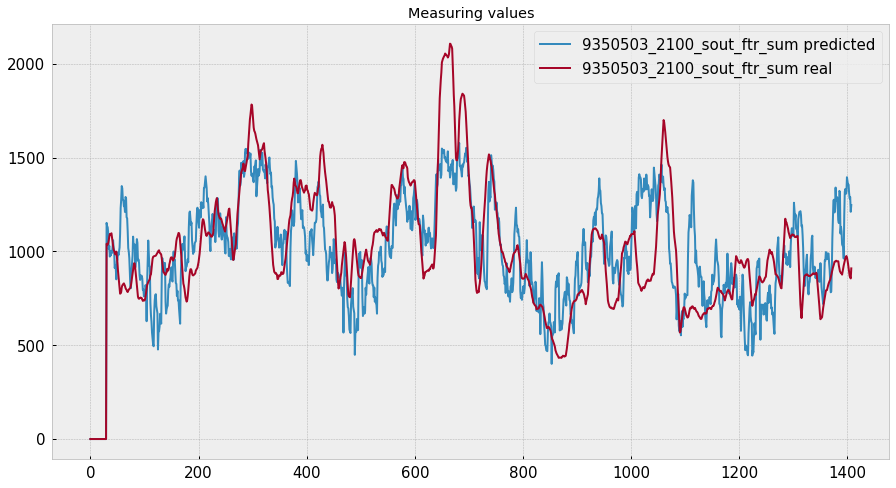

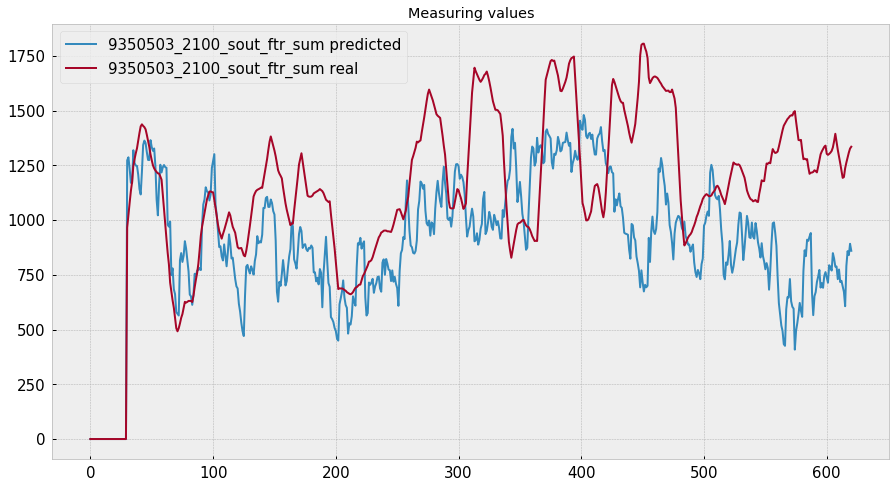

In [72]:
plot_predicted(X_train,y_train,model,range_low = 0,range_high=1)
plot_predicted(X_test,y_test,model,range_low = 0,range_high=1)

In [78]:
for i in item_vocab.keys():
    #make future features list
    #preparation
    _auto_ftr_list = ['%s_2100_sout'%i] 
    _data_out_4 = data_combiner_4(data_out_3_1,tag_ftr_names = auto_ftr_list,num_pred  = 30,ftr_only_one = True,ftr_sum=True)

    #prepare features for fitting
    _filter_columns = list(mean_columns)
    _filter_columns.extend([
        'cd',
            'date_month', 
            'date_day_long',
            'date_dayweek', 'date_week_year',
            'wd',      
            '%s_2100_sout_ftr_sum'%i
                     ])
    _target_name = '%s_2100_sout_ftr_sum'%i
    print(_filter_columns)
    #filter_columns
    _data_out_5 = _data_out_4[_filter_columns]

    #set dummies
    _data_out_6 = pd.concat([_data_out_5,pd.get_dummies(_data_out_5['date_month'],prefix = "dm")],axis = 1).drop('date_month',axis=1)
    _data_out_6 = pd.concat([_data_out_6,pd.get_dummies(_data_out_6['date_week_year'],prefix = "dw")],axis = 1).drop('date_week_year',axis=1)
    _data_out_6 = pd.concat([_data_out_6,pd.get_dummies(_data_out_6['date_dayweek'],prefix = "ddw")],axis = 1).drop('date_dayweek',axis=1)
    print(_data_out_6.columns)

['3809633_2100_sout', '8931762_2100_sout', '9350503_2100_sout', '8931832_2100_sout', '9391402_2100_sout', '3697643_2100_sout', '8433996_2100_sout', '8884623_2100_sout', 'total_sout', 'cd', 'date_month', 'date_day_long', 'date_dayweek', 'date_week_year', 'wd', '3809633_2100_sout_ftr_sum']


KeyError: "['3809633_2100_sout_ftr_sum'] not in index"